In [23]:
import io
from itertools import product
import logging
L = logging.getLogger(__name__)
from pathlib import Path
import pickle
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import sys
sys.path.append("..")
from berp.datasets import BerpDataset, NestedBerpDataset
from berp.datasets.base import assert_compatible
from berp.datasets.eeg import load_eeg_dataset
from berp.datasets.splitters import KFold, train_test_split
import berp.trainer  # sets some nice yaml dump defaults
from berp.viz.trf import plot_trf_coefficients

In [15]:
workflow = "heilbron2022"
model = "distilgpt2"

# base_model_run_name = "trf.20221219"
# trf_run_name = "trf-berp-fixed.20221215"
# trf_run_name = "trf-berp-cannon.20221215.3quant"
base_model_run_name = "trf"
trf_run_name = "trf-berp-fixed"

# TODO this can/should be reloaded via Hydra flow rather than manually re-specified + loaded with copy-pasted logic below
subjects = [14, 15, 16, 17, 18, 19]
runs = list(range(1, 20))
stories = ["old-man-and-the-sea"]

target_sensors = ["B19", "B2", "B20", "B22"]

# Match dataset spec.
normalize_X_ts = False
normalize_X_variable = True
normalize_Y = False

n_evaluation_folds = 4

In [16]:
all_run_names = [base_model_run_name, trf_run_name]
model_dirs = [f"../workflow/{workflow}/results/{model}/{run_name}"
              for run_name in all_run_names]
dataset_dir = f"../workflow/{workflow}/data/dataset/{model}"
stimulus_dir = f"../workflow/{workflow}/data/stimulus/{model}"

## Prepare dataset

In [17]:
# Load datasets.
ds = {}
stimulus_paths = {f"{story}/run{run}": Path(stimulus_dir) / f"{story}/run{run}.pkl"
                  for story in stories for run in runs}
combs = list(product(stories, subjects, runs))
ds_paths = []
for story, subject, run in tqdm(combs):
    ds_path = Path(dataset_dir) / story / f"sub{subject}" / f"run{run}.pkl"
    if not ds_path.exists():
        print(f"Could not find dataset {ds_path}")
        continue
    ds_paths.append(ds_path)
    
nested_ds = load_eeg_dataset(
    ds_paths,
    subset_sensors=target_sensors,
    stimulus_paths=stimulus_paths,
    normalize_X_ts=normalize_X_ts, 
    normalize_X_variable=normalize_X_variable, 
    normalize_Y=normalize_Y)

assert len(combs) == len(nested_ds.datasets)
ds = dict(zip(combs, nested_ds.datasets))

  0%|          | 0/114 [00:00<?, ?it/s]

In [18]:
ds = NestedBerpDataset(list(ds.values()), n_splits=8)
# TODO hack, just replicating what is in trainer.
ds_train, ds_test = train_test_split(ds, test_size=.25)

## Load and prime pipelines

In [26]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [27]:
pipes = []
for run in tqdm(model_dirs):
    pipeline_path = Path(run) / "params" / "pipeline.pkl"
    if not pipeline_path.exists():
        L.warn(f"Missing pipeline at {pipeline_path}")
    
    with pipeline_path.open("rb") as f:
        pipes.append(CPU_Unpickler(f).load())

  0%|          | 0/2 [00:00<?, ?it/s]

In [28]:
for run_name, pipe in zip(all_run_names, pipes):
    print(f"=============== {run_name}")
    yaml.safe_dump(pipe.get_params(), sys.stdout)
    print()

=============== trf
device: cuda
encoder: "TemporalReceptiveField(alpha=11878.459573823813, fit_intercept=True,\n \
  \                      n_outputs=4, name='e8008f5bcbb64f9ea44b6fa01e3073d2',\n \
  \                      optim=AdamSolver(n_batches=50,\n                        \
  \                name='e8008f5bcbb64f9ea44b6fa01e3073d2',\n                    \
  \                    random_state=RandomState(MT19937) at 0x2B9A4B928C40),\n   \
  \                    sfreq=128.0, tmax=1.0, tmin=0.0)"
encoder__alpha: 11878.459573823813
encoder__fit_intercept: true
encoder__init_scale: 0.1
encoder__n_outputs: 4
encoder__name: e8008f5bcbb64f9ea44b6fa01e3073d2
encoder__optim: "AdamSolver(n_batches=50, name='e8008f5bcbb64f9ea44b6fa01e3073d2',\n\
  \           random_state=RandomState(MT19937) at 0x2B9A4B928C40)"
encoder__optim__batch_size: 512
encoder__optim__early_stopping: 5
encoder__optim__learning_rate: 0.01
encoder__optim__n_batches: 50
encoder__optim__name: e8008f5bcbb64f9ea44b6fa01e30

In [29]:
for pipe in pipes:
    pipe.prime(ds)

## Estimate test score

In [30]:
test_scores = np.zeros((len(all_run_names), len(subjects), len(runs), len(target_sensors))) * np.nan
for j, (run_name, pipe) in enumerate(zip(tqdm(all_run_names, unit="pipe"), pipes)):
    test_scores[j] = pipe.score_multidimensional(ds_test).reshape((len(subjects), len(runs), len(target_sensors)))

  0%|          | 0/2 [00:00<?, ?pipe/s]

In [31]:
test_scores.max(axis=-1).mean(axis=-1).mean(axis=-1)

array([0.07539741, 0.07615573])

In [32]:
(test_scores[1] - test_scores[0]).max(axis=-1).mean()

0.0029283700456736576

### Bootstrap estimate

In [40]:
test_scores_df = []
for i_model_run, i_subj, i_run, i_sensor in np.ndindex(*test_scores.shape):
    test_scores_df.append((
        all_run_names[i_model_run],
        subjects[i_subj],
        runs[i_run],
        target_sensors[i_sensor],
        test_scores[i_model_run, i_subj, i_run, i_sensor]))
    
test_scores_df = pd.DataFrame(test_scores_df, columns=["model_run", "subject", "run", "sensor", "score"]).groupby(["model_run", "subject", "run"]).mean()
test_scores_df

score
model_run      subject run          
trf            14      1    0.079073
                       2    0.094011
                       3    0.144029
                       4    0.070826
                       5    0.069938
...                              ...
trf-berp-fixed 19      15   0.083802
                       16   0.044947
                       17  -0.017253
                       18  -0.019188
                       19   0.032959

[228 rows x 1 columns]

<AxesSubplot:xlabel='model_run', ylabel='score'>

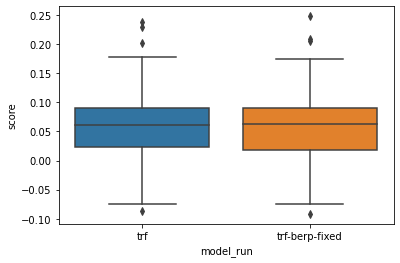

In [41]:
sns.boxplot(data=test_scores_df.reset_index(), x="model_run", y="score")

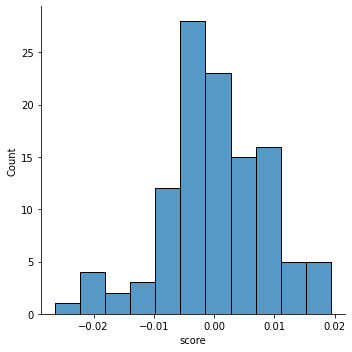

In [42]:
model_diffs = test_scores_df.loc[all_run_names[1]] - test_scores_df.loc[all_run_names[0]]
model_diffs = model_diffs.reset_index()
sns.displot(data=model_diffs, x="score")

95% bootstrap CI: [-0.00202754  0.00216361]


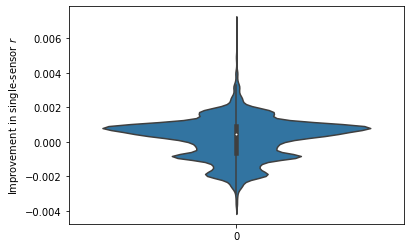

In [43]:
model_diffs_bootstrap = sns.algorithms.bootstrap(model_diffs.score, func="median", units=model_diffs.subject)
sns.violinplot(model_diffs_bootstrap)
plt.ylabel("Improvement in single-sensor $r$")
print("95% bootstrap CI:",
      np.quantile(model_diffs_bootstrap, (0.025, 0.975)))

In [ ]:
points, times = pipes[1].get_recognition_times(ds.datasets[0], pipes[1].params[0])
sns.displot(times - ds.datasets[0].word_onsets)

In [ ]:
sns.histplot(points)